In [1]:
import numpy as np
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

In [26]:
import sys, os
sys.path.insert(0, "/home/storage/hans/jax_reco_new")

from lib.geo import get_xyz_from_zenith_azimuth, rho_dom_relative_to_track, rho_dom_relative_to_track_v 

In [10]:
def get_perpendicular_dir(track_dir):
    '''
    track_dir: 1D jax array with 3 components [dir_x, dir_y, dir_z]
    '''
    dirx = track_dir[0]
    diry = track_dir[1]
    dirz = track_dir[2]

    perpz = jnp.where(jnp.logical_or(dirz == 1.0, dirz == -1.0), 0.0, jnp.sqrt(dirx**2 + diry**2))
    perpx = -dirx * dirz/perpz
    perpy = -diry * dirz/perpz
    return jnp.array([perpx, perpy, perpz])

In [9]:
np.arccos(-1.0) == np.pi

True

In [16]:
zenith = jnp.deg2rad(120.0)
azimuth = jnp.deg2rad(250.0)
track_dir = get_xyz_from_zenith_azimuth(jnp.array([zenith, azimuth]))
print(track_dir)

[0.29619813 0.81379768 0.5       ]


In [17]:
get_perpendicular_dir(track_dir)

Array([-0.17101007, -0.46984631,  0.8660254 ], dtype=float64)

In [152]:
__n_ice_phase = 1.30799291638281
__n_ice_group = 1.32548384613875
__n_ice = __n_ice_group
__theta_cherenkov = np.arccos(1/__n_ice_phase)
__sin_theta_cherenkov = np.sin(__theta_cherenkov)
__tan_theta_cherenkov = np.tan(__theta_cherenkov)
__c = 0.299792458 # m / ns
__c_ice = __c/__n_ice_group

def cherenkov_cylinder_coordinates_w_rho(dom_pos, track_pos, track_dir):
    """
    dom_pos: 1D jax array with 3 components [x, y, z]
    track_pos: 1D jax array with 3 components [x, y, z]
    track_dir: 1D jax array with 3 components [dir_x, dir_y, dir_z]
    """
    # vector from vertex to dom
    v_a = dom_pos - track_pos

    # distance muon travels from track vertex to point of closest approach.
    ds = jnp.dot(v_a, track_dir)

    # a vector parallel track with length ds
    ds_v = ds * track_dir

    # vector closest approach position to dom yields closest approach distance
    v_d = v_a - ds_v
    dc = jnp.linalg.norm(v_d)

    # vector to closest approach position gives z-component
    v_c = track_pos + ds_v
    v_c_z = v_c[2]

    # distance that the photon travel
    dt = dc / __sin_theta_cherenkov

    # distance emission point to closest approach point
    dx = dc / __tan_theta_cherenkov

    ### missing: add last return value -> rho angle of track
    perp_dir = get_perpendicular_dir(track_dir)
    cos_rho = -1.0 * jnp.dot(v_d, perp_dir) / dc
    cos_rho = jnp.where(dc > 0.0, cos_rho, 0.0)
    rho = jnp.arccos(cos_rho)
    
    rhosign = jnp.dot(jnp.cross(v_d, perp_dir), track_dir)
    rho = jnp.where(rhosign <= 0.0, rho, 2.0*jnp.pi-rho)
    rho = jnp.where(rho <= jnp.pi, rho, rho-2.0*jnp.pi) 
    
    
    return (ds - dx + dt * __n_ice_group) / __c, dc, v_c_z, rho


cherenkov_cylinder_coordinates_w_rho_v = jax.jit(jax.vmap(cherenkov_cylinder_coordinates_w_rho, (0, None, None), (0, 0, 0, 0)))

In [153]:
from lib.simdata_i3 import I3SimHandler
# Event Index.
event_index = 2

# Get an IceCube event.
bp = '/home/storage2/hans/i3files/21217'
sim_handler = I3SimHandler(os.path.join(bp, 'meta_ds_21217_from_35000_to_53530.ftr'),
                              os.path.join(bp, 'pulses_ds_21217_from_35000_to_53530.ftr'),
                              '/home/storage/hans/jax_reco/data/icecube/detector_geometry.csv')

meta, pulses = sim_handler.get_event_data(event_index)
print(f"muon energy: {meta['muon_energy_at_detector']/1.e3:.1f} TeV")

# Get dom locations, first hit times, and total charges (for each dom).
event_data = sim_handler.get_per_dom_summary_from_sim_data(meta, pulses)

muon energy: 4.7 TeV


In [165]:
# Make MCTruth seed.
track_pos = jnp.array([meta['muon_pos_x'], meta['muon_pos_y'], meta['muon_pos_z']])
track_time = meta['muon_time']
track_zenith = meta['muon_zenith']
track_azimuth = meta['muon_azimuth']
track_src = jnp.array([track_zenith, track_azimuth])

In [166]:
track_src_xyz = get_xyz_from_zenith_azimuth(track_src)

In [167]:
dom_pos = event_data[['x', 'y', 'z']].to_numpy()

In [168]:
rho1 = rho_dom_relative_to_track_v(dom_pos, track_pos, track_src_xyz)

In [169]:
print(rho1)

[ 0.66340451  0.93601187  1.00735912  0.2172808   0.31648282  0.45011542
 -0.97000883  1.34606692  0.11915926  0.17554798  0.22949579  0.56809677
  0.88505848  1.35305681 -0.57065445 -0.62294643 -0.68413604 -0.75610795
 -1.50186056 -1.19649709 -1.2619556   0.7672266   0.08505651  0.09343396
  0.10363526  0.11632564  0.13253648  0.15395475  0.1835352   0.22693959
  0.2964295   0.42364045  0.70977399 -1.56473782 -0.80450378 -0.46034039
 -0.31464    -0.23760561 -0.38290083 -0.61400418 -0.80441247 -0.8895663
 -0.98830683 -1.10172915 -1.22974942 -1.37027165 -1.51543875  1.46846368
  1.32196137  1.06194009  0.9535126   0.8594966   1.10696121  0.78556949
  0.85290916  0.92920458  1.01528567  1.21803893  1.3333851   1.45511885
 -1.55653649 -1.43354052 -0.99935241 -0.9150448   0.04776448  0.06334535
  0.07568075  0.09396231  0.12382174  0.18115198  0.33312197 -1.47185509
 -0.41080795 -0.2026133  -0.13355379 -0.09947574 -0.07922108 -0.06580836
 -0.05627523  1.56322054  1.07199354  0.80290941 -1.

In [170]:
_, _, _, rho2 = cherenkov_cylinder_coordinates_w_rho_v(dom_pos, track_pos, track_src_xyz)

In [171]:
rho2

Array([-2.47527798, -2.20029657, -2.12839845, -2.9225295 , -2.82136705,
       -2.68408998,  2.16187203, -1.78709432, -3.02168888, -2.96442816,
       -2.90933861, -2.55750892, -2.2221581 , -1.65427679,  2.56717524,
        2.51425111,  2.45229154,  2.37938666,  1.62298827,  1.94011261,
        1.87439982, -2.36994462, -3.05594313, -3.04744247, -3.03707535,
       -3.02415442, -3.00760994, -2.98568351, -2.95527544, -2.91039406,
       -2.83790023, -2.70325518, -2.39294045, -1.59012789, -0.76691675,
       -0.44540826, -0.30724579, -0.23327978,  2.75705083,  2.52366628,
        2.33102078,  2.24484913,  2.14496479,  2.03032243,  1.90108907,
        1.75937398,  1.60952623,  1.45801948,  1.31150383,  1.05327329,
        0.94592803,  0.85293513, -2.0306113 , -2.35110706, -2.28309969,
       -2.20605938, -2.11917156, -1.91475943, -1.79863746, -1.67593956,
       -1.54992267, -1.42463456, -0.99262982, -0.90906305, -3.09336896,
       -3.07743496, -3.06474714, -3.0458231 , -3.01459979, -2.95

(-180.0, 180.0)

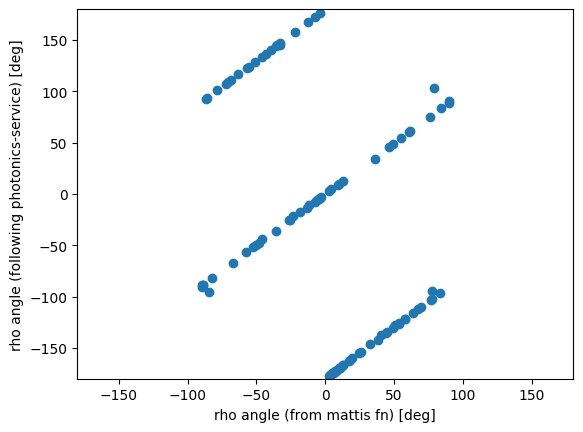

In [173]:
import matplotlib.pyplot as plt
plt.scatter(np.rad2deg(rho1), np.rad2deg(rho2))
plt.xlabel('rho angle (from mattis fn) [deg]')
plt.ylabel('rho angle (following photonics-service) [deg]')
plt.xlim([-180, 180])
plt.ylim([-180, 180])